# Определение возраста покупателей

# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. 

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении имеется набор фотографий людей с указанием возраста.

**Описание данных**

Данные взяты с сайта `ChaLearn Looking at People`. Они находятся в папке `/datasets/faces/`.

В наличии одна папка со всеми изображениями (`/final_files`) и CSV-файл `labels.csv` с двумя колонками: `file_name` и `real_age`.

## Исследовательский анализ данных

**Импорт необходимых библиотек**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Загрузка датасета с метками и именами файлов с изображениями**.

In [2]:
data_labels = pd.read_csv('/datasets/faces/labels.csv')

**Информация по датасету.**

In [3]:
data_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
data_labels.shape

(7591, 2)

In [5]:
data_labels.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


In [6]:
data_labels.sample(5)

,file_name,real_age
106,000106.jpg,45
3598,003598.jpg,15
5650,005650.jpg,14
2709,002709.jpg,17
5131,005131.jpg,39


Датасет содержит информацио о 7591 изображениях.

Пропусков в данных нету. 

Минимальный возраст 1 год, максимальный 100 лет.

Средний возраст 31,2 года.

**Гистограмма и ящик с усами для распределения возраста в датасете.**

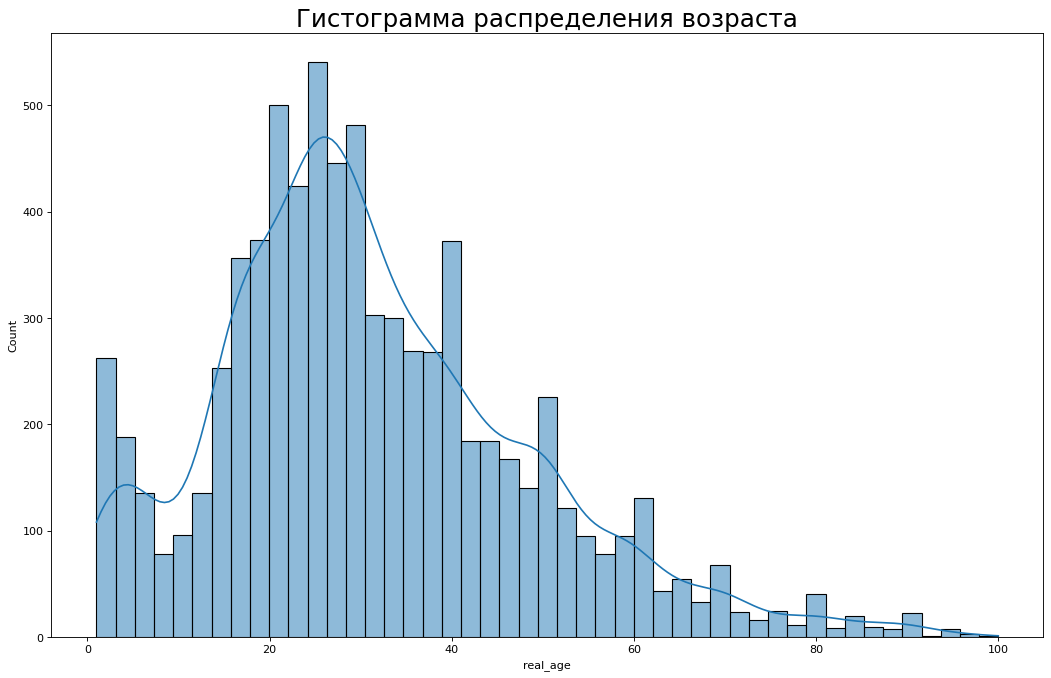

In [7]:
plt.figure(figsize=(16,10), dpi= 80)
sns.histplot(data=data_labels, x="real_age", kde=True)
plt.title('Гистограмма распределения возраста', fontsize=22)
plt.show()

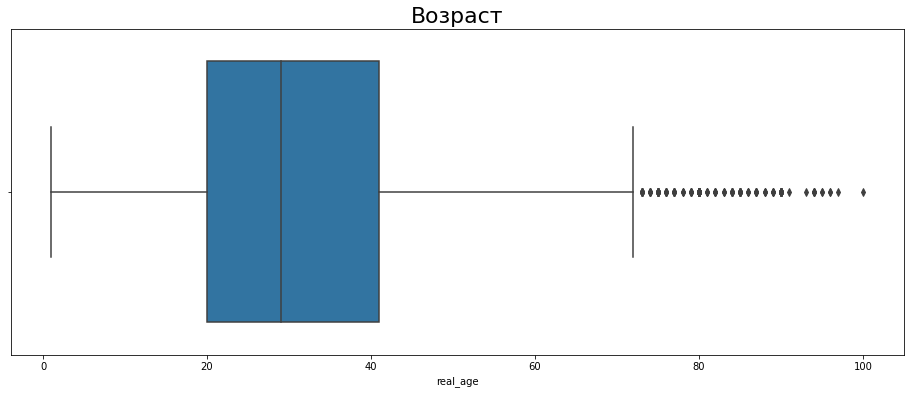

In [8]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=data_labels, x="real_age")
plt.title('Возраст', fontsize=22)
plt.show()

Распределение по возрасту напоминает нормальное.

Большинство фото по возрасту находятся в диапазоне от 20 лет до 41 года.

Есть выбросы, но с ними ничего не поделаешь.

**Вывод фото для ознакомления.**

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=data_labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


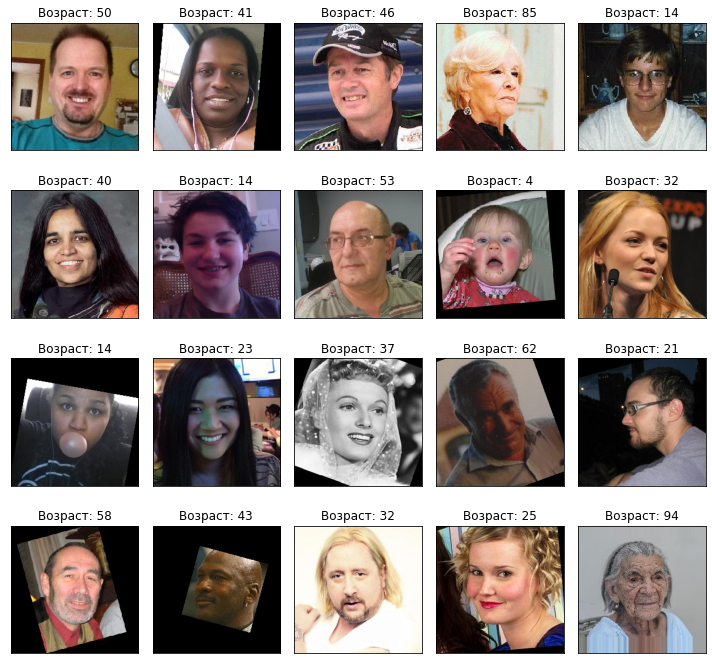

In [10]:
features, target = next(train_gen_flow)

# выводим 20 изображений
fig = plt.figure(figsize=(10,10))
for i in range(20):
    fig.add_subplot(4, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title("Возраст: " + str(target[i]))
    plt.tight_layout()

**Вывод.**

В датасете 7591 фотография.

Пропусков в данных нету. 

Минимальный возраст 1 год, максимальный 100 лет.

Средний возраст 31,2 года.

Есть ньюансы, которые могут повлиять на правильный прогноз:

- наличие доп. предметов на фото (картины, микрофон и т.п);
- часть фото в повернутых рамках;
- есть фото почти в профиль.

Плюс разметка по возрасту все-таки может ошибаться - люди могут выглядеть как моложе, так и старше своего возраста.

## Обучение модели

(Код в этом разделе запускался в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd


def load_train(path):
    
    labels = pd.read_csv(path+'labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       rescale=1./255,
                                       horizontal_flip=True)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                           directory=path + 'final_files/',
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           target_size=(224, 224),
                                                           batch_size=32,
                                                           class_mode='raw',
                                                           subset='training',
                                                           seed=12345)

    return train_datagen_flow
    

def load_test(path):
    
    labels = pd.read_csv(path+'labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25, 
                                      rescale=1./255)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                                         directory=path + 'final_files/',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='raw',
                                                         subset='validation',
                                                         seed=12345)

    return test_datagen_flow


def create_model(input_shape):
    
    optimizer = Adam(learning_rate = 0.0001)
    
    backbone = ResNet50(weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', input_shape=input_shape, include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

 
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
  
       
    callback = EarlyStopping(monitor='val_loss', 
                             patience=2, 
                             restore_best_weights=True) 
    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              callbacks=[callback],
              verbose=2)

    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
  
Train for 178 steps, validate for 60 steps
Epoch 1/20
178/178 - 54s - loss: 258.6045 - mae: 11.3909 - val_loss: 993.3480 - val_mae: 26.6785
Epoch 2/20
178/178 - 45s - loss: 77.4042 - mae: 6.6111 - val_loss: 700.4829 - val_mae: 21.0306
Epoch 3/20
178/178 - 43s - loss: 52.2639 - mae: 5.4918 - val_loss: 300.8956 - val_mae: 12.7224
Epoch 4/20
178/178 - 42s - loss: 37.5835 - mae: 4.6181 - val_loss: 96.4655 - val_mae: 7.5107
Epoch 5/20
178/178 - 44s - loss: 28.3234 - mae: 4.0799 - val_loss: 73.0712 - val_mae: 6.4012
Epoch 6/20
178/178 - 43s - loss: 22.2614 - mae: 3.6205 - val_loss: 75.0927 - val_mae: 6.4136
Epoch 7/20
178/178 - 45s - loss: 16.9141 - mae: 3.1284 - val_loss: 69.3311 - val_mae: 6.2868
Epoch 8/20
178/178 - 43s - loss: 14.6898 - mae: 2.9300 - val_loss: 83.3967 - val_mae: 6.7971
Epoch 9/20
178/178 - 43s - loss: 12.2448 - mae: 2.6639 - val_loss: 68.7646 - val_mae: 6.1041
Epoch 10/20
178/178 - 45s - loss: 10.3182 - mae: 2.4191 - val_loss: 79.9559 - val_mae: 6.5995
Epoch 11/20
178/178 - 44s - loss: 9.4393 - mae: 2.3429 - val_loss: 65.7631 - val_mae: 6.1252
Epoch 12/20
178/178 - 44s - loss: 8.0386 - mae: 2.1457 - val_loss: 63.7154 - val_mae: 5.8725
Epoch 13/20
178/178 - 45s - loss: 7.4350 - mae: 2.0646 - val_loss: 70.3484 - val_mae: 6.2131
Epoch 14/20
178/178 - 44s - loss: 7.5256 - mae: 2.0666 - val_loss: 66.6486 - val_mae: 6.1792
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 63.7154 - mae: 5.8725
Test MAE: 5.8725

```

## Анализ обученной модели

Была обучена модель с архитектурой ResNet в 50 слоёв.

Применен `GlobalAveragePooling2D` — пулинг с окном во весь тензор. 

Оптимизатор `Adam` с параметром `learning_rate = 0.0001`.

Соотношение трейн и тест - 75% на 25%.

Параметр `horizontal_flip` = True.

Количество эпох для обучения изначально было 20, но т.к. был применен метод ранней остановки `keras.callbacks.EarlyStopping` по параметру `val_loss` - модель получила результат за 14 эпох.

В `EarlyStopping` использован гиперпараметр`restore_best_weights=True` для фиксации лучшего результата и весов лучшего варианта модели.

`MAE` на тестовой выборке **5.8725**, что соответствует условию задачи получить метрику модели ниже **8**.

Модель можно рекомендовать для чтобы анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы, но это не касается алкогольной продукции. Ошибка в 6 лет тут критическая.

P.S. К сожалению тренажер не выдает результат предсказаний (только метрику), чтобы можно было посмотреть например в какой возрастной группе наибольшая ошибка и далее попытаться улучшить метрику для лучшей детекции по всем товарам. 

Па алкоголю ошибка детекции даже в 1 год может быть критичной, поэтому тут только проверка документов.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весьxкод выполняется без ошибок
- [x]  Ячейxи с кодом расположены в порядке исполнения
- [x]  Исслxдовательский анализ данных выполнен
- [x]  Резуxьтаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы